In [1]:
import os
import numpy as np
import pickle
#import deepchem as dc
#dc.__version__
from matchms import set_matchms_logger_level
import pandas as pd
set_matchms_logger_level("ERROR")
from matchms.filtering import add_losses
from matchms.filtering import add_parent_mass
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.importing import load_from_mgf
from matchms.exporting import save_as_mgf
from matchms.importing import load_from_msp


from matchms.filtering import repair_inchi_inchikey_smiles
from matchms.filtering import derive_inchikey_from_inchi
from matchms.filtering import derive_smiles_from_inchi
from matchms.filtering import derive_inchi_from_smiles
from matchms.filtering import harmonize_undefined_inchi
from matchms.filtering import harmonize_undefined_inchikey
from matchms.filtering import harmonize_undefined_smiles

Download GNPS not propagated 16.12.2022

In [2]:
%%time

#from spec2vec.model_building import train_new_word2vec_model

def spectrum_processing(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = default_filters(s)
    s = add_parent_mass(s)
    s = normalize_intensities(s)
    s = select_by_intensity(s, intensity_from=0.01)
    #s = reduce_to_number_of_peaks(s, n_required=10, n_max=500)
    s = select_by_mz(s, mz_from=15, mz_to=2000)
    #s = add_losses(s, loss_mz_from=15.0, loss_mz_to=350.0)
    s = require_minimum_number_of_peaks(s, n_required=5)
    return s



def metadata_processing(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = repair_inchi_inchikey_smiles(spectrum)
    spectrum = derive_inchi_from_smiles(spectrum)
    spectrum = derive_smiles_from_inchi(spectrum)
    spectrum = derive_inchikey_from_inchi(spectrum)
    spectrum = harmonize_undefined_smiles(spectrum)
    spectrum = harmonize_undefined_inchi(spectrum)
    spectrum = harmonize_undefined_inchikey(spectrum)
    return spectrum
# Load data from MGF file and apply filters


path_data = "/Users/delser/downloads/"  # enter path to downloaded mgf file
file_mgf = os.path.join(path_data, 
                        "ALL_GNPS_NO_PROPOGATED.mgf")
spectrums = list(load_from_mgf(file_mgf))

spectrums = [metadata_processing(s) for s in spectrums]
spectrums = [spectrum_processing(s) for s in spectrums]
#spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/delser/Desktop/PhD/Phytochemistry/NP-Databases/CFM-4_DB/TOTAL_COMPOUNDS_DB.energies_merged_name.mgf")]
#spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/delser/Desktop/PhD/Phytochemistry/FBMN/alltissues/altissues15072021-py.mgf")]
# Omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

RDKit ERROR: [10:49:05] ERROR: 
[10:49:05] ERROR: 
[10:49:07] ERROR: 
[10:49:07] ERROR: 
[10:49:07] ERROR: 
[10:49:07] ERROR: 
[10:49:07] ERROR: 
[10:49:08] Explicit valence for atom # 49 Na, 2, is greater than permitted
RDKit ERROR: [10:49:07] ERROR: 
RDKit ERROR: [10:49:07] ERROR: 
RDKit ERROR: [10:49:07] ERROR: 
RDKit ERROR: [10:49:07] ERROR: 
RDKit ERROR: [10:49:07] ERROR: 
RDKit ERROR: [10:49:08] Explicit valence for atom # 49 Na, 2, is greater than permitted
RDKit ERROR: [10:49:08] Explicit valence for atom # 49 Na, 2, is greater than permitted
RDKit WARNING: [10:49:04] WARNING: Omitted undefined stereo
RDKit WARNING: [10:49:05] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
RDKit WARNING: [10:49:05] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
RDKit WARNING: [10:49:05] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: L

CPU times: user 30min 48s, sys: 53.7 s, total: 31min 42s
Wall time: 32min 49s


In [3]:
len(spectrums)

329050

In [8]:
spectrums=[i for i in spectrums if i.metadata['pi'] != "BMDMS-NP"]

In [10]:
number_of_peaks = np.array([len(s.peaks) for s in spectrums])
print(f"{np.sum(number_of_peaks > 250)} spectra have > 250 peaks")

4240 spectra have > 250 peaks


In [12]:
noisy = [s for s in spectrums if len(s.peaks) > 250 ]
#len([x for x in instrumments_HR if x in i.metadata['source_instrument'].lower()])

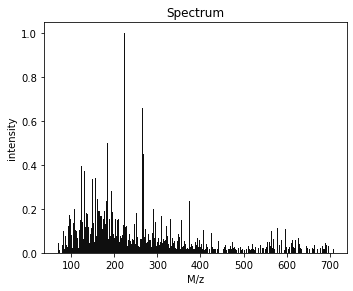

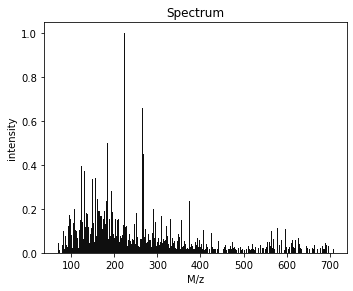

In [16]:
noisy[300].plot()

In [17]:
def spectrum_processing(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = reduce_to_number_of_peaks(s, n_required=5, n_max=250)
    #s = select_by_mz(s, mz_from=15, mz_to=2000)
    #s = add_losses(s, loss_mz_from=15.0, loss_mz_to=350.0)
    #s = require_minimum_number_of_peaks(s, n_required=5)
    return s
noisy = [spectrum_processing(s) for s in noisy]

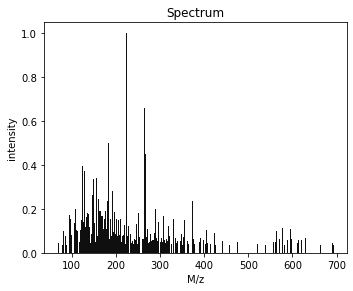

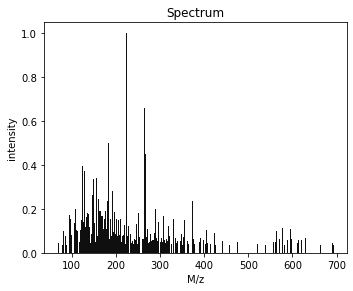

In [18]:
noisy[300].plot()

In [19]:
def spectrum_processing(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = reduce_to_number_of_peaks(s, n_required=5, n_max=250)
    #s = select_by_mz(s, mz_from=15, mz_to=2000)
    s = add_losses(s, loss_mz_from=15.0, loss_mz_to=350.0)
    #s = require_minimum_number_of_peaks(s, n_required=5)
    return s
spectrums = [spectrum_processing(s) for s in spectrums]

In [20]:
final_names = []
for spectrum in spectrums:
    name_original = spectrum.get("compound_name")
    name = name_original.replace("F dial M", "")
    # Remove last word if likely not correct:
    if name.split(" ")[-1] in ["M", "M?", "?", "M+2H/2", "MS34+Na", "M]", "Cat+M]", "Unk", "--"]:
        name = " ".join(name.split(" ")[:-1]).strip()
    if name != name_original:
        final_names.append((name_original, name))
        print(f"Changed compound name from {name_original} to {name}.")
        spectrum.set("compound_name", name)

Changed compound name from Hoiamide_A_triacetate MS34+Na to Hoiamide_A_triacetate.
Changed compound name from Calcium-dependent antibiotic (putative) Unk to Calcium-dependent antibiotic (putative).
Changed compound name from Calcium-dependent antibiotic (putative) Unk to Calcium-dependent antibiotic (putative).
Changed compound name from Calcium-dependent antibiotic (putative) Unk to Calcium-dependent antibiotic (putative).
Changed compound name from Calcium-dependent antibiotic (putative) Unk to Calcium-dependent antibiotic (putative).
Changed compound name from Calcium-dependent antibiotic (putative) Unk to Calcium-dependent antibiotic (putative).
Changed compound name from Plipastatin (multiple species) Unk to Plipastatin (multiple species).
Changed compound name from Plipastatin (multiple species) Unk to Plipastatin (multiple species).
Changed compound name from Plipastatin (multiple species) Unk to Plipastatin (multiple species).
Changed compound name from PQS-C9:1 or NQNO-C9:1 Un

In [21]:
ionmode=[]
for i in spectrums:
    if i.metadata["ionmode"].lower() not in ionmode:
        ionmode.append(i.metadata["ionmode"].lower())
        
    
ionmode  

['positive', 'negative', 'n/a']

In [22]:
instrument=[]
for i in spectrums:
    if i.metadata['source_instrument'].lower() not in instrument:
        instrument.append(i.metadata['source_instrument'].lower())
instrument        
#instruments_all=["esi",'-q-exactive plus orbitrap res 14k','-q-exactive plus orbitrap res 70k','-maxis hd qtof']
#instrumments_HR=["q-tof","qtof","tof","ft","exactive","orbitrap","lumos","velos","impact hd","maxis"] not "apci"


['lc-esi-qtof',
 'lc-esi-ion trap',
 'lc-esi-hybrid ft',
 'lc-esi-ger',
 'di-esi-ion trap',
 'di-esi-qtof',
 'di-esi-hybrid ft',
 'lc-esims-qtof',
 'lc-esi-lcq',
 'di-esi-ltq-ft-icr',
 'lc-esi-ltq-fticr',
 'esi-q-tof',
 'esi-qtof',
 'esi-maxis',
 'di-esi-q-exactive',
 'di-esi-orbitrap',
 'lc-esi-orbitrap',
 'lc-esi-qqq',
 'esi-orbitrap',
 'di-esi-qqq',
 'apci-qtof',
 'apci-orbitrap',
 'esi-ion trap',
 'ei-qqq',
 'lc-esi-maxis ii hd q-tof bruker',
 'di-esi-q-exactive plus',
 'lc-esi-q-exactive plus',
 'lc-esi-q-exactive plus orbitrap res 14k',
 'lc-esi-q-exactive plus orbitrap res 70k',
 '-q-exactive plus orbitrap res 14k',
 'lc-esi-maxis hd qtof',
 '-q-exactive plus orbitrap res 70k',
 '-maxis hd qtof',
 'lc-apci-qtof',
 'esi-qqq',
 'ci (meoh)-it/ion trap',
 'lc-esi-lc-esi-qtof',
 'esi-it/ion trap',
 'esi-hcd',
 'in-source cid-api',
 'esi-it-ft/ion trap with ftms',
 'esi or apci-it/ion trap',
 'apci-ion trap',
 'esi-qqit',
 'fab-beqq/magnetic and electric sectors with quadrupole',
 'in

In [23]:
#### filter all HRMS instruments positive mode and esi and have a smiles
filter_HRMS=[]
counter=0
instrumments_HR=["q-tof","qtof","tof","ft","exactive","orbitrap","lumos","velos","impact hd","maxis"]
for i in spectrums:
    if i.metadata['smiles'] != '' and len([x for x in instrumments_HR if x in i.metadata['source_instrument'].lower()]) ==1 and "apci" not in i.metadata['source_instrument'].lower() and i.metadata["ionmode"].lower() =="positive":
        filter_HRMS.append(i)
        counter+=1

print(counter)  


61119


In [24]:
# here we recover missing adducts as M+H
no_adducts=[]
for i, b in enumerate(filter_HRMS):
    adduct=b.get("adduct")
    if adduct is None:
        no_adducts.append(i)
        
for ids in no_adducts:
    precursor_mz=filter_HRMS[ids].get("precursor_mz")
    parent_mass=filter_HRMS[ids].get("parent_mass")
    MH=float(precursor_mz)-float(parent_mass)
    if int(MH) == 1:
        filter_HRMS[ids].set("adduct", "[M+H]+")
    else:
        pass
for i, b in enumerate(filter_HRMS):
    adduct=b.get("adduct")
    if adduct is None:
        print(i)

In [25]:
def count_annotations(spectra):
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    for i, spec in enumerate(spectra):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")

In [26]:
count_annotations(spectrums) 

Inchis: 169526 -- 26396 unique
Smiles: 169142 -- 35848 unique
Inchikeys: 169113 -- 22801 unique (first 14 characters)


In [30]:
#import pickle
pickle.dump(spectrums, 
            open(os.path.join("/Users/delser/mass2smiles/retrain", 'ALL_GNPS_cleaned_by_matchms_16122022.pickle'), "wb"))

In [28]:
import pickle
path_data = "/Users/delser/mass2smiles/retrain" 
outfile = os.path.join(path_data, 'compositebmdms_math_500.pickle')
with open(outfile, 'rb') as file:
    compositebmdms = pickle.load(file)

In [29]:
def spectrum_processing(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = normalize_intensities(s)
    s = select_by_intensity(s, intensity_from=0.01)
    s = reduce_to_number_of_peaks(s, n_required=5, n_max=250)
    s = select_by_mz(s, mz_from=15, mz_to=2000)
    s = add_losses(s, loss_mz_from=15.0, loss_mz_to=350.0)
    s = require_minimum_number_of_peaks(s, n_required=5)
    return s

compositebmdms= [spectrum_processing(s) for s in compositebmdms]
compositebmdms = [s for s in compositebmdms if s is not None]
len(compositebmdms)

2719

In [37]:
compositebmdms[0].metadata

{'name': 'Chrysin',
 'precursormz': '255.09',
 'precursortype': '[M+H]+',
 'ionmode': 'positive',
 'formula': 'C15H10O4',
 'smiles': 'O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC=CC3',
 'inchikey': 'RTIXKCRFFJGDFG-UHFFFAOYSA-N',
 'ionization': 'ESI',
 'instrumenttype': 'Orbitrap',
 'collisionenergy': '10',
 'retentiontime': '7.09',
 'ccs': '156.8268947',
 'ontology': 'Flavones',
 'comment': 'spec_id=16; origin=BMDMS-NP',
 'num peaks': '7',
 'compound_name': 'Chrysin',
 'precursor_mz': 255.09,
 'charge': 1,
 'inchi': 'InChI=1S/C15H10O4/c16-10-6-11(17)15-12(18)8-13(19-14(15)7-10)9-4-2-1-3-5-9/h1-8,16-17H',
 'parent_mass': 254.08272354800926,
 'adduct': '[M+H]+',
 'spectrumid': 'spec_id=16'}

# Load the mFAM DB

In [31]:
path_data = "/Users/delser/mass2smiles/retrain"  # enter path to downloaded mgf file
file_msp = os.path.join(path_data, 
                        "MassBank_RIKEN_827f4647050bf91f615fe4216842608c66125972.msp")
mfam = list(load_from_msp(file_msp))

mfam = [metadata_processing(s) for s in mfam]
mfam = [spectrum_processing(s) for s in mfam]
#spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/delser/Desktop/PhD/Phytochemistry/NP-Databases/CFM-4_DB/TOTAL_COMPOUNDS_DB.energies_merged_name.mgf")]
#spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/delser/Desktop/PhD/Phytochemistry/FBMN/alltissues/altissues15072021-py.mgf")]
# Omit spectrums that didn't qualify for analysis
mfam = [s for s in mfam if s is not None]


# Create spectrum documents
#reference_documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]


In [32]:
len(mfam)

7606

In [34]:
mfam[0].metadata

{'name ': '(25S)-3beta,16beta-Diacetoxy-22,26-imino-5alpha-cholest-22(N)-en',
 'precursormz': '498.36000',
 'adductionname': '[M-H]-',
 'instrumenttype': 'APCI-ITFT',
 'instrument': 'Orbitrap Elite',
 'smiles': 'C[C@H]1CCC([C@@H](C)[C@H]2[C@@H](OC(C)=O)C[C@@]3([H])[C@]4([H])CC[C@@]5([H])C[C@@H](OC(C)=O)CC[C@]5(C)[C@@]4([H])CC[C@]23C)=NC1',
 'inchikey': 'AVFPEFZPKZCVMP-PSBTVZOFSA-N',
 'inchi': 'InChI=1S/C31H49NO4/c1-18-7-10-27(32-17-18)19(2)29-28(36-21(4)34)16-26-24-9-8-22-15-23(35-20(3)33)11-13-30(22,5)25(24)12-14-31(26,29)6/h18-19,22-26,28-29H,7-17H2,1-6H3/t18-,19+,22-,23-,24+,25-,26-,28-,29-,30-,31-/m0/s1',
 'formula': 'C31H49NO4',
 'retentiontime': 'null',
 'ionmode': 'negative',
 'links': 'INCHIKEY:AVFPEFZPKZCVMP-PSBTVZOFSA-N; ChemOnt:Organic compounds;Lipids and lipid-like molecules;Steroids and steroid derivatives;Steroidal alkaloids;22,26-epiminocholestanes',
 'comment': 'DB#=MSBNK-Alena_Soboleva_IPB-Alena_Soboleva_negative_IPB_new_mC003801; origin=MassBank; Annotation Pure stan

In [35]:
#### filter all HRMS instruments positive mode and esi and have a smiles
mfam_HRMS=[]
counter=0
instrumments_HR=["q-tof","qtof","tof","ft","exactive","orbitrap","lumos","velos","impact hd","maxis"]
for i in mfam:
    if i.metadata['smiles'] != '' and len([x for x in instrumments_HR if x in i.metadata['instrumenttype'].lower()]) ==1 and "apci" not in i.metadata['instrumenttype'].lower() and i.metadata["ionmode"].lower() =="positive":
        mfam_HRMS.append(i)
        counter+=1

print(counter)  


2582


In [36]:
for i in mfam_HRMS:
    adduct=i.metadata['adductionname']
    i._metadata['adduct']=adduct

In [39]:
mfam_HRMS[0].metadata

{'name ': 'Prostaglandin F2-alpha dimethyl amide',
 'precursormz': '382.29591',
 'adductionname': '[M+H]+',
 'instrumenttype': 'ESI-TOF',
 'instrument': 'waters xevo g2 TOF',
 'smiles': 'O[C@@H]1[C@H](C/C=C\\CCCC(N(C)C)=O)[C@@H](/C=C/[C@@H](O)CCCCC)[C@H](O)C1',
 'inchikey': 'QGAWKBHDDFBNMX-GWSKAPOCSA-N',
 'inchi': 'InChI=1S/C22H39NO4/c1-4-5-8-11-17(24)14-15-19-18(20(25)16-21(19)26)12-9-6-7-10-13-22(27)23(2)3/h6,9,14-15,17-21,24-26H,4-5,7-8,10-13,16H2,1-3H3/b9-6-,15-14+/t17-,18+,19+,20-,21+/m0/s1',
 'formula': 'C22H39NO4',
 'retentiontime': 'null',
 'ionmode': 'positive',
 'links': 'INCHIKEY:QGAWKBHDDFBNMX-GWSKAPOCSA-N; ChemOnt:Organic compounds;Lipids and lipid-like molecules;Fatty Acyls;Eicosanoids;Prostaglandins and related compounds',
 'comment': 'DB#=MSBNK-Corey_Broeckling_CSU-Corey_Broeckling_CS_mC038501; origin=MassBank; Annotation Pure standard; ID 385',
 'num peaks': '49',
 'precursor_mz': 382.29591,
 'charge': 1,
 'adduct': '[M+H]+'}

In [44]:
mfam_HRMS[999].metadata['comment'].split(";")[0]

'DB#=MSBNK-Corey_Broeckling_CSU-Corey_Broeckling_CS_mC026701'

In [45]:
for i in mfam_HRMS:
    i._metadata['spectrumid']=i.metadata['comment'].split(";")[0]

In [46]:
mfam_HRMS[0].metadata

{'name ': 'Prostaglandin F2-alpha dimethyl amide',
 'precursormz': '382.29591',
 'adductionname': '[M+H]+',
 'instrumenttype': 'ESI-TOF',
 'instrument': 'waters xevo g2 TOF',
 'smiles': 'O[C@@H]1[C@H](C/C=C\\CCCC(N(C)C)=O)[C@@H](/C=C/[C@@H](O)CCCCC)[C@H](O)C1',
 'inchikey': 'QGAWKBHDDFBNMX-GWSKAPOCSA-N',
 'inchi': 'InChI=1S/C22H39NO4/c1-4-5-8-11-17(24)14-15-19-18(20(25)16-21(19)26)12-9-6-7-10-13-22(27)23(2)3/h6,9,14-15,17-21,24-26H,4-5,7-8,10-13,16H2,1-3H3/b9-6-,15-14+/t17-,18+,19+,20-,21+/m0/s1',
 'formula': 'C22H39NO4',
 'retentiontime': 'null',
 'ionmode': 'positive',
 'links': 'INCHIKEY:QGAWKBHDDFBNMX-GWSKAPOCSA-N; ChemOnt:Organic compounds;Lipids and lipid-like molecules;Fatty Acyls;Eicosanoids;Prostaglandins and related compounds',
 'comment': 'DB#=MSBNK-Corey_Broeckling_CSU-Corey_Broeckling_CS_mC038501; origin=MassBank; Annotation Pure standard; ID 385',
 'num peaks': '49',
 'precursor_mz': 382.29591,
 'charge': 1,
 'adduct': '[M+H]+',
 'spectrumid': 'DB#=MSBNK-Corey_Broeckling_

# Load the RIKEN plasma DB

In [47]:
path_data = "/Users/delser/mass2smiles/retrain"  # enter path to downloaded mgf file
file_msp = os.path.join(path_data, 
                        "MSMS-Pos-PlaSMA.msp")
plasma = list(load_from_msp(file_msp))

plasma  = [metadata_processing(s) for s in plasma ]
plasma = [spectrum_processing(s) for s in plasma ]
#spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/delser/Desktop/PhD/Phytochemistry/NP-Databases/CFM-4_DB/TOTAL_COMPOUNDS_DB.energies_merged_name.mgf")]
#spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/delser/Desktop/PhD/Phytochemistry/FBMN/alltissues/altissues15072021-py.mgf")]
# Omit spectrums that didn't qualify for analysis
plasma  = [s for s in plasma  if s is not None]


# Create spectrum documents
#reference_documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]


RDKit WARNING: [11:13:47] WARNING: Omitted undefined stereo
tted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Omitted undefined stereo
[11:13:47] WARNING: Proton(s) added/removed
[11:13:47] WARNING: Proton(s) added/removed
[11:13:47] WARNING: Proton(s) added/removed
[11:13:47] WARNING: Proton(s) added/removed
[11:13:47] WARNING: Proton(s) added/removed
[11:13:47] WARNING: Pro

In [48]:
len(plasma)

3697

In [50]:
plasma[0].metadata

{'name': 'Gelsenicine',
 'precursormz': '327.170319',
 'precursortype': '[M+H]+',
 'formula': 'C19H22N2O3',
 'ontology': 'Indoles and derivatives',
 'inchikey': 'BIGABVPVCRHEES-NWPJSNQLSA-N',
 'smiles': 'CCC1=N[C@H]2C[C@]3([C@H]4C[C@@H]1[C@@H]2CO4)C(=O)N(OC)C1=CC=CC=C31',
 'retentiontime': '3.986933',
 'ccs': '182.1064128',
 'ionmode': 'positive',
 'instrumenttype': 'LC-ESI-QTOF',
 'instrument': '',
 'collisionenergy': '10',
 'comment': 'registered in RIKEN PlaSMA',
 'num peaks': '58',
 'compound_name': 'Gelsenicine',
 'precursor_mz': 327.170319,
 'charge': 1,
 'inchi': 'InChI=1S/C19H22N2O3/c1-3-14-11-8-17-19(9-15(20-14)12(11)10-24-17)13-6-4-5-7-16(13)21(23-2)18(19)22/h4-7,11-12,15,17H,3,8-10H2,1-2H3/t11-,12+,15+,17-,19+/m1/s1'}

In [51]:
instrument=[]
for i in plasma:
    if i.metadata['instrumenttype'].lower() not in instrument:
        instrument.append(i.metadata['instrumenttype'].lower())
instrument    

['lc-esi-qtof']

In [56]:
for n,i in enumerate(plasma):
    i._metadata['spectrumid']=i.metadata['name']+"_plasma_"+str(n)

In [58]:
plasma[11].metadata

{'name': 'Isoformosanine',
 'precursormz': '369.1808837',
 'precursortype': '[M+H]+',
 'formula': 'C21H24N2O4',
 'ontology': 'Indolizidines',
 'inchikey': 'JMIAZDVHNCCPDM-DQDWJNSRSA-N',
 'smiles': 'COC(=O)C1=CO[C@H](C)[C@H]2CN3CC[C@]4([C@@H]3C[C@H]12)C(O)=NC1=CC=CC=C41',
 'retentiontime': '4.424',
 'ccs': '188.7218789',
 'ionmode': 'positive',
 'instrumenttype': 'LC-ESI-QTOF',
 'instrument': '',
 'collisionenergy': '50',
 'comment': 'registered in RIKEN PlaSMA',
 'num peaks': '177',
 'compound_name': 'Isoformosanine',
 'precursor_mz': 369.1808837,
 'charge': 1,
 'inchi': 'InChI=1S/C21H24N2O4/c1-12-14-10-23-8-7-21(16-5-3-4-6-17(16)22-20(21)25)18(23)9-13(14)15(11-27-12)19(24)26-2/h3-6,11-14,18H,7-10H2,1-2H3,(H,22,25)/t12-,13+,14-,18+,21+/m1/s1',
 'spectrumid': 'Isoformosanine_plasma_11'}

In [59]:
for i in plasma:
    adduct=i.metadata['precursortype']
    i._metadata['adduct']=adduct

In [60]:
plasma[11].metadata

{'name': 'Isoformosanine',
 'precursormz': '369.1808837',
 'precursortype': '[M+H]+',
 'formula': 'C21H24N2O4',
 'ontology': 'Indolizidines',
 'inchikey': 'JMIAZDVHNCCPDM-DQDWJNSRSA-N',
 'smiles': 'COC(=O)C1=CO[C@H](C)[C@H]2CN3CC[C@]4([C@@H]3C[C@H]12)C(O)=NC1=CC=CC=C41',
 'retentiontime': '4.424',
 'ccs': '188.7218789',
 'ionmode': 'positive',
 'instrumenttype': 'LC-ESI-QTOF',
 'instrument': '',
 'collisionenergy': '50',
 'comment': 'registered in RIKEN PlaSMA',
 'num peaks': '177',
 'compound_name': 'Isoformosanine',
 'precursor_mz': 369.1808837,
 'charge': 1,
 'inchi': 'InChI=1S/C21H24N2O4/c1-12-14-10-23-8-7-21(16-5-3-4-6-17(16)22-20(21)25)18(23)9-13(14)15(11-27-12)19(24)26-2/h3-6,11-14,18H,7-10H2,1-2H3,(H,22,25)/t12-,13+,14-,18+,21+/m1/s1',
 'spectrumid': 'Isoformosanine_plasma_11',
 'adduct': '[M+H]+'}

# Load the NIST composite DB

In [11]:
path_data = "/Users/delser/mass2smiles/retrain"
outfile = os.path.join(path_data, 'composite_nist_pos_math_500.pickle')

with open(outfile, 'rb') as file:
    nist_comp = pickle.load(file)

In [12]:
nist_comp[0].metadata

{'name': "1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho]-sn-glycerol",
 'notes': 'Consensus spectrum; Water/isopropanol/Formic acid; added_Vial_ID=4487',
 'precursor_type': '[M+NH4]+',
 'spectrum_type': 'MS2',
 'precursormz': '1467.0061',
 'instrument_type': 'Q-TOF',
 'instrument': 'Agilent QTOF 6530',
 'sample_inlet': 'direct flow injection',
 'ionization': 'ESI',
 'in-source_voltage': '150',
 'collision_gas': 'N2',
 'collision_energy': '8',
 'ion_mode': 'P',
 'inchikey': 'LSHJMDWWJIYXEM-XGJIDDIWSA-N',
 'synon': '8,11-Octadecadienoic acid, 5,8,11-trihydroxy-5,11-dioxido-4,6,10,12-tetraoxa-5,11-diphosphapentadecane-1,2,14,15-tetrayl ester',
 'formula': 'C81H142O17P2',
 'mw': '1448',
 'exactmass': '1448.97223',
 'casno': '746600942',
 'nistno': '1035166',
 'id': '1',
 'comment': 'NIST Mass Spectrometry Data Center',
 'num peaks': '15',
 'ionmode': 'n/a',
 'compound_name': "1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho]-sn-glycerol",
 'precursor_mz': 1467.0061,
 'charge': 0,
 'smiles':

In [13]:
for i in nist_comp: # fix two precursors
    if len(i.metadata['precursormz'].split(','))!=1:
        i._metadata['precursor_mz']=float(i.metadata['precursormz'].split(',')[0])
    
multi_pre=[]
for i in nist_comp:
    if type(i.metadata['precursor_mz'])!=float:
        multi_pre.append(i)
    else:
        pass
len(multi_pre)   

0

In [14]:
def spectrum_processing2(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = normalize_intensities(s)
    s = select_by_intensity(s, intensity_from=0.01)
    s = reduce_to_number_of_peaks(s, n_required=5, n_max=250)
    s = select_by_mz(s, mz_from=15, mz_to=2000)
    s = add_losses(s, loss_mz_from=15.0, loss_mz_to=350.0)
    s = require_minimum_number_of_peaks(s, n_required=5)
    return s

nist_comp = [spectrum_processing2(s) for s in nist_comp]
nist_comp  = [s for s in nist_comp  if s is not None]

In [64]:
nist_comp[0].metadata

{'name': "1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho]-sn-glycerol",
 'notes': 'Consensus spectrum; Water/isopropanol/Formic acid; added_Vial_ID=4487',
 'precursor_type': '[M+NH4]+',
 'spectrum_type': 'MS2',
 'precursormz': '1467.0061',
 'instrument_type': 'Q-TOF',
 'instrument': 'Agilent QTOF 6530',
 'sample_inlet': 'direct flow injection',
 'ionization': 'ESI',
 'in-source_voltage': '150',
 'collision_gas': 'N2',
 'collision_energy': '8',
 'ion_mode': 'P',
 'inchikey': 'LSHJMDWWJIYXEM-XGJIDDIWSA-N',
 'synon': '8,11-Octadecadienoic acid, 5,8,11-trihydroxy-5,11-dioxido-4,6,10,12-tetraoxa-5,11-diphosphapentadecane-1,2,14,15-tetrayl ester',
 'formula': 'C81H142O17P2',
 'mw': '1448',
 'exactmass': '1448.97223',
 'casno': '746600942',
 'nistno': '1035166',
 'id': '1',
 'comment': 'NIST Mass Spectrometry Data Center',
 'num peaks': '15',
 'ionmode': 'n/a',
 'compound_name': "1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho]-sn-glycerol",
 'precursor_mz': 1467.0061,
 'charge': 0,
 'smiles':

In [65]:
all_specs=filter_HRMS+compositebmdms+mfam_HRMS+plasma+nist_comp 

In [66]:
count_annotations(all_specs) 

Inchis: 70106 -- 12869 unique
Smiles: 96401 -- 39904 unique
Inchikeys: 96390 -- 32854 unique (first 14 characters)


In [70]:
precs = []
IDs = []
mzs=[]
ints=[]
loss_mzs=[]
loss_ints=[]
smiles=[]
inchikey=[]
adduct=[]

for spec in all_specs: 
    IDs.append(spec.get("spectrumid"))
    adduct.append(spec.get("adduct"))
    smiles.append(spec.get("smiles"))
    inchikey.append(spec.get("inchikey"))
    precs.append(spec.get("precursor_mz"))
    mzs.append(list(spec.peaks.mz))
    ints.append(list(spec.peaks.intensities))
    loss_mzs.append(list(spec.losses.mz))
    loss_ints.append(list(spec.losses.intensities))
    
    

In [80]:
metadata = pd.DataFrame(list(zip(IDs,adduct, precs,mzs,ints,loss_mzs,loss_ints,smiles,inchikey)), columns=["spectrum_id","adduct", "precursor_mz","mzs","intensities","loss_mzs","loss_intensities",'smiles','inchikey' ])
metadata

,spectrum_id,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,smiles,inchikey
0,CCMSLIB00000001555,[M+H]+,665.1150,"[218.156921, 370.177979, 406.058289, 424.09008...","[0.013223301694675707, 0.04426626435749063, 0....","[18.082896000000005, 36.10511199999996, 42.076...","[0.010584576035636336, 0.06389042141415535, 0....",C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[C...,USXIYWCPCGVOKF-NOENWEJRSA-N
1,CCMSLIB00000001564,[M+H]+,567.0000,"[208.177307, 227.343689, 434.228668, 470.07461...","[0.1570009563248263, 0.014943931117290503, 0.0...","[31.896361999999954, 96.925385, 132.7713319999...","[0.02642132737617843, 1.0, 0.02907553793873546...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#CBr)=C\Cl)=C...,NAIKIJSSBJHCBL-IPUGVWFUSA-N
2,CCMSLIB00000001565,[M+Na]+,589.0000,"[182.204346, 197.179382, 199.111526, 228.43579...","[0.10113276188831438, 0.011209280715908133, 0....","[15.985168000000044, 16.932433999999944, 17.80...","[0.02767285337811825, 0.025537970786305517, 0....",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#CBr)=C\Cl)=C...,NAIKIJSSBJHCBL-IPUGVWFUSA-N
3,CCMSLIB00000001569,[M+H]+,489.0000,"[182.29068, 208.143951, 229.291229, 236.30101,...","[0.012646198682922362, 0.22043296638116253, 0....","[31.787108999999987, 96.84845000000001, 132.69...","[0.02839475769485916, 1.0, 0.03307956864643711...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#C)=C\Cl)=C\C...,KZVHAGNFWJIOMX-GDKFLGFMSA-N
4,CCMSLIB00000001571,[M+Na]+,511.0000,"[230.178528, 246.417114, 304.173706, 347.33374...","[0.06989673183875082, 0.010321807739041478, 0....","[31.762389999999982, 35.66308600000002, 49.160...","[0.2697956842968271, 0.0340548091939678, 0.032...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#C)=C\Cl)=C\C...,KZVHAGNFWJIOMX-GDKFLGFMSA-N
...,...,...,...,...,...,...,...,...,...
96396,NIST1026289,[M+H]+,991.6676,"[150.0543, 151.0381, 164.9197, 167.0329, 178.0...","[0.06669669669669669, 0.0536036036036036, 0.06...","[17.0086, 18.009000000000015, 21.0059999999999...","[0.3739039039039039, 1.0, 0.0390990990990991, ...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,PKLSFJOTJYLMTM-CGAFSULGSA-N
96397,NIST1026354,[M+Na]+,1725.9398,"[150.0543, 151.038, 154.0491, 164.92, 166.0492...","[0.4609009009009009, 0.6249049049049049, 0.107...","[27.028500000000122, 28.033800000000156, 201.0...","[0.0278978978978979, 0.0301001001001001, 0.045...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,ONUDHQSSNJFFIP-ZRZKNOLTSA-N
96398,NIST1026421,[M+Na]+,1697.9085,"[150.0542, 151.0385, 155.0178, 158.996, 164.91...","[0.1529029029029029, 0.20909909909909907, 0.07...","[186.11149999999998, 187.1177, 201.0815, 202.0...","[0.0627027027027027, 0.09080080080080079, 0.04...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,CXQCLLQQYTUUKJ-GWOMXWBBSA-N
96399,NIST1026604,[M+H]+,864.6229,"[236.2361, 252.2673, 253.2704, 254.2838, 264.2...","[0.014204204204204204, 0.1011011011011011, 0.0...","[17.009699999999953, 18.01369999999997, 78.956...","[0.020100100100100098, 0.056196196196196195, 0...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD-GJOJTGTQSA-N


In [81]:
metadata.to_csv('all_hrms_16122022.tsv',sep='\t')

# We will now remove Salt and isomeric information

In [87]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover



def get_clean(smiles):
    remover = SaltRemover()
    try:
        m=Chem.MolFromSmiles(smiles)
        stripped=remover.StripMol( m )
        clean=Chem.MolToSmiles(stripped,isomericSmiles=False)
        return clean
    except:
        return None
    

In [88]:
get_clean("[C@H]1(C2=CN=CC=C2)CCCN1")

'c1cncc(C2CCCN2)c1'

In [89]:
metadata['smiles_clean'] = metadata.apply(lambda x: get_clean(x.smiles), axis=1)
metadata

RDKit ERROR: [15:32:46] Explicit valence for atom # 22 O, 3, is greater than permitted
[15:32:46] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [15:32:46] Explicit valence for atom # 31 O, 3, is greater than permitted
[15:32:46] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [15:32:46] Explicit valence for atom # 6 O, 3, is greater than permitted
[15:32:46] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [15:32:46] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:32:46] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [15:32:46] Explicit valence for atom # 4 O, 3, is greater than permitted
[15:32:46] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [15:32:46] Explicit valence for atom # 7 O, 3, is greater than permitted
[15:32:46] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [15:32:46] Explicit valence f

,spectrum_id,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,smiles,inchikey,smiles_clean
0,CCMSLIB00000001555,[M+H]+,665.1150,"[218.156921, 370.177979, 406.058289, 424.09008...","[0.013223301694675707, 0.04426626435749063, 0....","[18.082896000000005, 36.10511199999996, 42.076...","[0.010584576035636336, 0.06389042141415535, 0....",C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[C...,USXIYWCPCGVOKF-NOENWEJRSA-N,CC(=O)OC1c2nc(cs2)C(=O)OC(CCCC(C)(Cl)Cl)C(C)C(...
1,CCMSLIB00000001564,[M+H]+,567.0000,"[208.177307, 227.343689, 434.228668, 470.07461...","[0.1570009563248263, 0.014943931117290503, 0.0...","[31.896361999999954, 96.925385, 132.7713319999...","[0.02642132737617843, 1.0, 0.02907553793873546...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#CBr)=C\Cl)=C...,NAIKIJSSBJHCBL-IPUGVWFUSA-N,COC(=CC(=O)N1C(=O)C=CC1C)CCNC(=O)CCC=CC(C)CCC(...
2,CCMSLIB00000001565,[M+Na]+,589.0000,"[182.204346, 197.179382, 199.111526, 228.43579...","[0.10113276188831438, 0.011209280715908133, 0....","[15.985168000000044, 16.932433999999944, 17.80...","[0.02767285337811825, 0.025537970786305517, 0....",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#CBr)=C\Cl)=C...,NAIKIJSSBJHCBL-IPUGVWFUSA-N,COC(=CC(=O)N1C(=O)C=CC1C)CCNC(=O)CCC=CC(C)CCC(...
3,CCMSLIB00000001569,[M+H]+,489.0000,"[182.29068, 208.143951, 229.291229, 236.30101,...","[0.012646198682922362, 0.22043296638116253, 0....","[31.787108999999987, 96.84845000000001, 132.69...","[0.02839475769485916, 1.0, 0.03307956864643711...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#C)=C\Cl)=C\C...,KZVHAGNFWJIOMX-GDKFLGFMSA-N,C#CCCCC(=CCl)CCC(C)C=CCCC(=O)NCCC(=CC(=O)N1C(=...
4,CCMSLIB00000001571,[M+Na]+,511.0000,"[230.178528, 246.417114, 304.173706, 347.33374...","[0.06989673183875082, 0.010321807739041478, 0....","[31.762389999999982, 35.66308600000002, 49.160...","[0.2697956842968271, 0.0340548091939678, 0.032...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#C)=C\Cl)=C\C...,KZVHAGNFWJIOMX-GDKFLGFMSA-N,C#CCCCC(=CCl)CCC(C)C=CCCC(=O)NCCC(=CC(=O)N1C(=...
...,...,...,...,...,...,...,...,...,...,...
96396,NIST1026289,[M+H]+,991.6676,"[150.0543, 151.0381, 164.9197, 167.0329, 178.0...","[0.06669669669669669, 0.0536036036036036, 0.06...","[17.0086, 18.009000000000015, 21.0059999999999...","[0.3739039039039039, 1.0, 0.0390990990990991, ...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,PKLSFJOTJYLMTM-CGAFSULGSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(O)C(OC2(C(=O...
96397,NIST1026354,[M+Na]+,1725.9398,"[150.0543, 151.038, 154.0491, 164.92, 166.0492...","[0.4609009009009009, 0.6249049049049049, 0.107...","[27.028500000000122, 28.033800000000156, 201.0...","[0.0278978978978979, 0.0301001001001001, 0.045...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,ONUDHQSSNJFFIP-ZRZKNOLTSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(OC2OC(CO)C(O...
96398,NIST1026421,[M+Na]+,1697.9085,"[150.0542, 151.0385, 155.0178, 158.996, 164.91...","[0.1529029029029029, 0.20909909909909907, 0.07...","[186.11149999999998, 187.1177, 201.0815, 202.0...","[0.0627027027027027, 0.09080080080080079, 0.04...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,CXQCLLQQYTUUKJ-GWOMXWBBSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(OC2OC(CO)C(O...
96399,NIST1026604,[M+H]+,864.6229,"[236.2361, 252.2673, 253.2704, 254.2838, 264.2...","[0.014204204204204204, 0.1011011011011011, 0.0...","[17.009699999999953, 18.01369999999997, 78.956...","[0.020100100100100098, 0.056196196196196195, 0...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD-GJOJTGTQSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(O)C(OS(=O)(=...


In [91]:
metadata = metadata.replace(to_replace='None', value=np.nan).dropna()
metadata

,spectrum_id,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,smiles,inchikey,smiles_clean
0,CCMSLIB00000001555,[M+H]+,665.1150,"[218.156921, 370.177979, 406.058289, 424.09008...","[0.013223301694675707, 0.04426626435749063, 0....","[18.082896000000005, 36.10511199999996, 42.076...","[0.010584576035636336, 0.06389042141415535, 0....",C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[C...,USXIYWCPCGVOKF-NOENWEJRSA-N,CC(=O)OC1c2nc(cs2)C(=O)OC(CCCC(C)(Cl)Cl)C(C)C(...
1,CCMSLIB00000001564,[M+H]+,567.0000,"[208.177307, 227.343689, 434.228668, 470.07461...","[0.1570009563248263, 0.014943931117290503, 0.0...","[31.896361999999954, 96.925385, 132.7713319999...","[0.02642132737617843, 1.0, 0.02907553793873546...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#CBr)=C\Cl)=C...,NAIKIJSSBJHCBL-IPUGVWFUSA-N,COC(=CC(=O)N1C(=O)C=CC1C)CCNC(=O)CCC=CC(C)CCC(...
2,CCMSLIB00000001565,[M+Na]+,589.0000,"[182.204346, 197.179382, 199.111526, 228.43579...","[0.10113276188831438, 0.011209280715908133, 0....","[15.985168000000044, 16.932433999999944, 17.80...","[0.02767285337811825, 0.025537970786305517, 0....",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#CBr)=C\Cl)=C...,NAIKIJSSBJHCBL-IPUGVWFUSA-N,COC(=CC(=O)N1C(=O)C=CC1C)CCNC(=O)CCC=CC(C)CCC(...
3,CCMSLIB00000001569,[M+H]+,489.0000,"[182.29068, 208.143951, 229.291229, 236.30101,...","[0.012646198682922362, 0.22043296638116253, 0....","[31.787108999999987, 96.84845000000001, 132.69...","[0.02839475769485916, 1.0, 0.03307956864643711...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#C)=C\Cl)=C\C...,KZVHAGNFWJIOMX-GDKFLGFMSA-N,C#CCCCC(=CCl)CCC(C)C=CCCC(=O)NCCC(=CC(=O)N1C(=...
4,CCMSLIB00000001571,[M+Na]+,511.0000,"[230.178528, 246.417114, 304.173706, 347.33374...","[0.06989673183875082, 0.010321807739041478, 0....","[31.762389999999982, 35.66308600000002, 49.160...","[0.2697956842968271, 0.0340548091939678, 0.032...",CO\C(CCNC(=O)CC\C=C\C(C)CC\C(CCCC#C)=C\Cl)=C\C...,KZVHAGNFWJIOMX-GDKFLGFMSA-N,C#CCCCC(=CCl)CCC(C)C=CCCC(=O)NCCC(=CC(=O)N1C(=...
...,...,...,...,...,...,...,...,...,...,...
96396,NIST1026289,[M+H]+,991.6676,"[150.0543, 151.0381, 164.9197, 167.0329, 178.0...","[0.06669669669669669, 0.0536036036036036, 0.06...","[17.0086, 18.009000000000015, 21.0059999999999...","[0.3739039039039039, 1.0, 0.0390990990990991, ...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,PKLSFJOTJYLMTM-CGAFSULGSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(O)C(OC2(C(=O...
96397,NIST1026354,[M+Na]+,1725.9398,"[150.0543, 151.038, 154.0491, 164.92, 166.0492...","[0.4609009009009009, 0.6249049049049049, 0.107...","[27.028500000000122, 28.033800000000156, 201.0...","[0.0278978978978979, 0.0301001001001001, 0.045...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,ONUDHQSSNJFFIP-ZRZKNOLTSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(OC2OC(CO)C(O...
96398,NIST1026421,[M+Na]+,1697.9085,"[150.0542, 151.0385, 155.0178, 158.996, 164.91...","[0.1529029029029029, 0.20909909909909907, 0.07...","[186.11149999999998, 187.1177, 201.0815, 202.0...","[0.0627027027027027, 0.09080080080080079, 0.04...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,CXQCLLQQYTUUKJ-GWOMXWBBSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(OC2OC(CO)C(O...
96399,NIST1026604,[M+H]+,864.6229,"[236.2361, 252.2673, 253.2704, 254.2838, 264.2...","[0.014204204204204204, 0.1011011011011011, 0.0...","[17.009699999999953, 18.01369999999997, 78.956...","[0.020100100100100098, 0.056196196196196195, 0...",CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD-GJOJTGTQSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(O)C(OS(=O)(=...


In [92]:
metadata=metadata.drop(['smiles'], axis=1)
metadata=metadata.rename(columns={"smiles_clean": "smiles"})
metadata

,spectrum_id,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,inchikey,smiles
0,CCMSLIB00000001555,[M+H]+,665.1150,"[218.156921, 370.177979, 406.058289, 424.09008...","[0.013223301694675707, 0.04426626435749063, 0....","[18.082896000000005, 36.10511199999996, 42.076...","[0.010584576035636336, 0.06389042141415535, 0....",USXIYWCPCGVOKF-NOENWEJRSA-N,CC(=O)OC1c2nc(cs2)C(=O)OC(CCCC(C)(Cl)Cl)C(C)C(...
1,CCMSLIB00000001564,[M+H]+,567.0000,"[208.177307, 227.343689, 434.228668, 470.07461...","[0.1570009563248263, 0.014943931117290503, 0.0...","[31.896361999999954, 96.925385, 132.7713319999...","[0.02642132737617843, 1.0, 0.02907553793873546...",NAIKIJSSBJHCBL-IPUGVWFUSA-N,COC(=CC(=O)N1C(=O)C=CC1C)CCNC(=O)CCC=CC(C)CCC(...
2,CCMSLIB00000001565,[M+Na]+,589.0000,"[182.204346, 197.179382, 199.111526, 228.43579...","[0.10113276188831438, 0.011209280715908133, 0....","[15.985168000000044, 16.932433999999944, 17.80...","[0.02767285337811825, 0.025537970786305517, 0....",NAIKIJSSBJHCBL-IPUGVWFUSA-N,COC(=CC(=O)N1C(=O)C=CC1C)CCNC(=O)CCC=CC(C)CCC(...
3,CCMSLIB00000001569,[M+H]+,489.0000,"[182.29068, 208.143951, 229.291229, 236.30101,...","[0.012646198682922362, 0.22043296638116253, 0....","[31.787108999999987, 96.84845000000001, 132.69...","[0.02839475769485916, 1.0, 0.03307956864643711...",KZVHAGNFWJIOMX-GDKFLGFMSA-N,C#CCCCC(=CCl)CCC(C)C=CCCC(=O)NCCC(=CC(=O)N1C(=...
4,CCMSLIB00000001571,[M+Na]+,511.0000,"[230.178528, 246.417114, 304.173706, 347.33374...","[0.06989673183875082, 0.010321807739041478, 0....","[31.762389999999982, 35.66308600000002, 49.160...","[0.2697956842968271, 0.0340548091939678, 0.032...",KZVHAGNFWJIOMX-GDKFLGFMSA-N,C#CCCCC(=CCl)CCC(C)C=CCCC(=O)NCCC(=CC(=O)N1C(=...
...,...,...,...,...,...,...,...,...,...
96396,NIST1026289,[M+H]+,991.6676,"[150.0543, 151.0381, 164.9197, 167.0329, 178.0...","[0.06669669669669669, 0.0536036036036036, 0.06...","[17.0086, 18.009000000000015, 21.0059999999999...","[0.3739039039039039, 1.0, 0.0390990990990991, ...",PKLSFJOTJYLMTM-CGAFSULGSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(O)C(OC2(C(=O...
96397,NIST1026354,[M+Na]+,1725.9398,"[150.0543, 151.038, 154.0491, 164.92, 166.0492...","[0.4609009009009009, 0.6249049049049049, 0.107...","[27.028500000000122, 28.033800000000156, 201.0...","[0.0278978978978979, 0.0301001001001001, 0.045...",ONUDHQSSNJFFIP-ZRZKNOLTSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(OC2OC(CO)C(O...
96398,NIST1026421,[M+Na]+,1697.9085,"[150.0542, 151.0385, 155.0178, 158.996, 164.91...","[0.1529029029029029, 0.20909909909909907, 0.07...","[186.11149999999998, 187.1177, 201.0815, 202.0...","[0.0627027027027027, 0.09080080080080079, 0.04...",CXQCLLQQYTUUKJ-GWOMXWBBSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(OC2OC(CO)C(O...
96399,NIST1026604,[M+H]+,864.6229,"[236.2361, 252.2673, 253.2704, 254.2838, 264.2...","[0.014204204204204204, 0.1011011011011011, 0.0...","[17.009699999999953, 18.01369999999997, 78.956...","[0.020100100100100098, 0.056196196196196195, 0...",UAKYQMHTPLVMJD-GJOJTGTQSA-N,CCCCCCCCCCCCCC=CC(O)C(COC1OC(CO)C(O)C(OS(=O)(=...


# Shuffle data randomly and the look for duplicates by Inchikey

In [95]:
metadata = metadata.sample(frac = 1)
metadata=metadata.set_index("spectrum_id")
df_key=metadata['inchikey'].str.split('-', expand=True)
df_key_index=df_key.reset_index().set_index(0)
df_unique=df_key.drop_duplicates(subset=0, keep="last")
df_unique

,0,1,2
spectrum_id,,,
NIST690971,OYDLKUZQSIKGSE,UHFFFAOYSA,N
NIST919333,DXQDHJSBBMMJOY,UHFFFAOYSA,N
NIST924994,ILWFNCDBGMJBKA,UHFFFAOYSA,N
spec_id=77922,QVUPQEXKTXSMKX,JJDILSOYSA,N
NIST27504,ATHZHGQSAIJHQU,UHFFFAOYSA,N
...,...,...,...
CCMSLIB00004697526,OJDSCNUKKOKOQJ,RKQHYHRCSA,N
CCMSLIB00005770518,ASUTZQLVASHGKV,UHFFFAOYSA,N
CCMSLIB00004698553,FWHAYHIGJSFGKO,UHFFFAOYSA,N


# We have 32854 unique structures
# we shuffle again and then retrieve our validaion fraction

In [96]:
df_unique_shuffle = df_unique.sample(frac = 1)
df_unique_val = df_unique.sample(frac = 0.025)
df_unique_val[0].tolist()
df_validation_ids=df_key_index.loc[df_unique_val[0].tolist()]
df_validation_ids

,spectrum_id,1,2
0,,,
ROODQCZSWXEDJL,NIST461939,UHFFFAOYSA,N
NIHNMOSRSAYZIT,NIST29556,UHFFFAOYSA,N
IQDIERHFZVCNRZ,NIST324933,LRCDAWNTSA,N
IQDIERHFZVCNRZ,NIST135188,GAJVHJNZSA,N
IQDIERHFZVCNRZ,CCMSLIB00010115820,YUYPDVIUSA,N
...,...,...,...
OKEKLOJNCOIPIT,NIST305966,UHFFFAOYSA,N
HKNSYAPUOMHZDE,CCMSLIB00005436088,RCJATNNHSA,N
HKNSYAPUOMHZDE,CCMSLIB00008851460,RCJATNNHSA,N


In [97]:
df_validation_ids=df_validation_ids.reset_index().drop_duplicates(subset=0, keep="last")
df_validation_ids

,0,spectrum_id,1,2
0,ROODQCZSWXEDJL,NIST461939,UHFFFAOYSA,N
1,NIHNMOSRSAYZIT,NIST29556,UHFFFAOYSA,N
6,IQDIERHFZVCNRZ,spec_id=91278,LRCDAWNTSA,N
7,WGOUYULOZZRTFS,NIST93607,UHFFFAOYSA,N
8,IJSTZKWSILWQEC,NIST100718,KTKRTIGZSA,N
...,...,...,...,...
2482,NOQJBXPAMJLUSS,CCMSLIB00010115746,UHFFFAOYSA,N
2483,OKEKLOJNCOIPIT,NIST305966,UHFFFAOYSA,N
2485,HKNSYAPUOMHZDE,CCMSLIB00008851460,RCJATNNHSA,N
2486,XIKYOEXOYRWIOU,spec_id=100330,HJBGGDBQSA,N


In [107]:
df_validation=metadata.loc[df_validation_ids["spectrum_id"].tolist()]
df_validation

,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,inchikey,smiles
spectrum_id,,,,,,,,
NIST461939,[M+H]+,192.0291,"[52.0183, 53.0023, 55.0542, 56.9648, 61.0074, ...","[0.0543043043043043, 0.020600600600600597, 0.0...","[17.0069, 18.010500000000008, 27.9949, 45.0021...","[0.1072972972972973, 1.0, 0.08420420420420421,...",ROODQCZSWXEDJL-UHFFFAOYSA-N,O=C1Nc2c(C(=O)O)cccc2C1=O
NIST29556,[M+H]+,409.2194,"[44.05, 60.05, 60.06, 65.04, 70.03, 70.06, 70....","[0.20549549549549548, 0.13490490490490492, 0.1...","[17.01940000000002, 17.02940000000001, 35.0394...","[0.025795795795795794, 0.0596996996996997, 0.0...",NIHNMOSRSAYZIT-UHFFFAOYSA-N,CC(NC(=O)C(N)Cc1ccc(O)cc1)C(=O)NC(CCCNC(=N)N)C...
spec_id=91278,[M+Na]+,452.3100,"[79.054, 80.049, 81.069, 82.065, 84.08, 91.054...","[0.041, 0.011, 0.014, 0.011, 0.013, 0.023, 0.0...","[20.004999999999995, 21.00999999999999, 21.968...","[0.011, 0.345, 0.032, 0.155, 0.366, 1.0, 0.156...",IQDIERHFZVCNRZ-LRCDAWNTSA-N,CC1CCC2N(C1)CC1C3CC4C(CC(=O)C5CC(O)CCC54C)C3CC...
NIST93607,[M+H]+,267.1016,"[50.015, 51.0228, 52.0304, 53.0018, 53.0383, 6...","[0.23783783783783782, 0.6777877877877878, 0.02...","[15.025800000000032, 27.99630000000002, 43.020...","[0.13939939939939938, 0.0473973973973974, 0.44...",WGOUYULOZZRTFS-UHFFFAOYSA-N,COc1cc(C)c2c(=O)c(-c3ccccc3)coc2c1
NIST100718,[M+H]+,417.2764,"[68.9889, 71.0045, 71.0492, 77.0386, 78.9944, ...","[0.0229029029029029, 0.0997997997997998, 0.726...","[22.019600000000025, 48.07140000000004, 56.061...","[0.015695695695695695, 0.012202202202202202, 0...",IJSTZKWSILWQEC-KTKRTIGZSA-N,CCCCCCCCC=CCCCCCCCC(=O)OCC1CCP(=O)(O)O1
...,...,...,...,...,...,...,...,...
CCMSLIB00010115746,[M+H]+,237.0910,"[79.054543, 91.054367, 103.054199, 107.049088,...","[0.010528080361442269, 0.04621692332056106, 0....","[59.01344, 71.01333300000002, 84.0362970000000...","[0.023516228769935726, 0.017276972418492194, 0...",NOQJBXPAMJLUSS-UHFFFAOYSA-N,Cc1ccc2oc(-c3ccccc3)cc(=O)c2c1
NIST305966,[M+H]+,834.3695,"[51.0227, 55.0176, 55.054, 65.0383, 67.0539, 6...","[0.1981981981981982, 0.1213013013013013, 0.134...","[78.03409999999997, 160.07720000000006, 242.14...","[0.1601001001001001, 0.0968968968968969, 0.193...",OKEKLOJNCOIPIT-UHFFFAOYSA-N,CCC(C)C(=O)NC(c1ccccc1)C(O)C(=O)OC1CC2(O)C(OC(...
CCMSLIB00008851460,[M+H]+,387.2170,"[51.547672, 53.359512, 59.501995, 59.505276, 6...","[0.014954232320952082, 0.015079173023819678, 0...","[15.997089999999957, 17.007222000000013, 18.01...","[0.01709269959282713, 0.09103336541564197, 0.4...",HKNSYAPUOMHZDE-RCJATNNHSA-N,CC1CCC2C(C)(C)C(O)CCC2(C)C12Cc1c(O)cc3c(c1O2)C...


# We have 821 specs for validation without duplicates

In [109]:
set(metadata['adduct'].to_list())

{'[2M+ACN+H]+',
 '[2M+Ca-H]+',
 '[2M+Ca]2+',
 '[2M+H+2i]+',
 '[2M+H+CH3CN]',
 '[2M+H]+',
 '[2M+K]+',
 '[2M+NH4]',
 '[2M+NH4]+',
 '[2M+Na]+',
 '[2M-H+2Na]+',
 '[2M-H2O+H]+',
 '[3M+H]+',
 '[Cat+2I]+',
 '[Cat+H2O]+',
 '[Cat+H2O]2+',
 '[Cat+H]2+',
 '[Cat-C14H10O2]+',
 '[Cat-C18H36]+',
 '[Cat-C6H10O4]+',
 '[Cat-H2O]+',
 '[Cat-H]+',
 '[Cat]+',
 '[Cat]2+',
 '[M+2H+2i]2+',
 '[M+2H]2+',
 '[M+2Na-H]+',
 '[M+2Na]',
 '[M+2Na]2+',
 '[M+3Na-2H]+',
 '[M+4Na-3H]+',
 '[M+8Na-6H]2+',
 '[M+ACN+2H]2+',
 '[M+ACN+H]+',
 '[M+ACN+Na]+',
 '[M+Ca-H]+',
 '[M+Ca]2+',
 '[M+Cl]-',
 '[M+H+2i]+',
 '[M+H+C2H6OS]',
 '[M+H+CH3CN]',
 '[M+H+CH3OH]',
 '[M+H+H2O+2i]+',
 '[M+H+H2O]+',
 '[M+H+HCOOH]',
 '[M+H+NH3]+',
 '[M+H+Na]2+',
 '[M+H+i]+',
 '[M+H-2H2O]+',
 '[M+H-3H2O]+',
 '[M+H-C10H10O4]+',
 '[M+H-C10H9N]+',
 '[M+H-C11H14O4]+',
 '[M+H-C11H8N2O3]+',
 '[M+H-C12H10O]+',
 '[M+H-C12H15NO]+',
 '[M+H-C12H17NO]+',
 '[M+H-C12H20O9]+',
 '[M+H-C12H22O10]+',
 '[M+H-C12H22O9]+',
 '[M+H-C13H17NO]+',
 '[M+H-C14H11NO2]+',
 '[M+H-C15H10O2

In [112]:
ADDUCTS=['[2M+ACN+H]+',
 '[2M+Ca-H]+',
 '[2M+H+2i]+',
 '[2M+H+CH3CN]',
 '[2M+H]+',
 '[2M+K]+',
 '[2M+NH4]',
 '[2M+NH4]+',
 '[2M+Na]+',
 '[2M-H+2Na]+',
 '[2M-H2O+H]+',
 '[3M+H]+',
 '[Cat+2I]+',
 '[Cat+H2O]+',
 '[Cat+H]2+',
 '[Cat-C14H10O2]+',
 '[Cat-C18H36]+',
 '[Cat-C6H10O4]+',
 '[Cat-H2O]+',
 '[Cat-H]+',
 '[Cat]+',
 '[M+2Na-H]+',
 '[M+2Na]',
 '[M+3Na-2H]+',
 '[M+4Na-3H]+',
 '[M+ACN+H]+',
 '[M+ACN+Na]+',
 '[M+Ca-H]+',
 '[M+H+2i]+',
 '[M+H+C2H6OS]',
 '[M+H+CH3CN]',
 '[M+H+CH3OH]',
 '[M+H+H2O+2i]+',
 '[M+H+H2O]+',
 '[M+H+HCOOH]',
 '[M+H+NH3]+',
 '[M+H+i]+',
 '[M+H-2H2O]+',
 '[M+H-3H2O]+',
 '[M+H-C10H10O4]+',
 '[M+H-C10H9N]+',
 '[M+H-C11H14O4]+',
 '[M+H-C11H8N2O3]+',
 '[M+H-C12H10O]+',
 '[M+H-C12H15NO]+',
 '[M+H-C12H17NO]+',
 '[M+H-C12H20O9]+',
 '[M+H-C12H22O10]+',
 '[M+H-C12H22O9]+',
 '[M+H-C13H17NO]+',
 '[M+H-C14H11NO2]+',
 '[M+H-C15H10O2]+',
 '[M+H-C16H24O6]+',
 '[M+H-C16H36O3]+',
 '[M+H-C17H17IO6]+',
 '[M+H-C17H28O15]+',
 '[M+H-C18H18O6]+',
 '[M+H-C18H26O4]+',
 '[M+H-C18H30O15]+',
 '[M+H-C18H32O15]+',
 '[M+H-C2H2F3NO]+',
 '[M+H-C2H2O]+',
 '[M+H-C2H4+2i]+',
 '[M+H-C2H4ClNO]+',
 '[M+H-C2H4O+2i]+',
 '[M+H-C2H4O2]+',
 '[M+H-C2H4S+2i]+',
 '[M+H-C2H4SO2]+',
 '[M+H-C2H4]+',
 '[M+H-C2H5N]+',
 '[M+H-C2H6O+2i]+',
 '[M+H-C2H6O]+',
 '[M+H-C2H7N]+',
 '[M+H-C2HClO+2i]+',
 '[M+H-C2O2]+',
 '[M+H-C3H2N2]+',
 '[M+H-C3H4N2S+2i]+',
 '[M+H-C3H4N2]+',
 '[M+H-C3H4O4]+',
 '[M+H-C3H5NO]+',
 '[M+H-C3H6O2+2i]+',
 '[M+H-C3H9NO]+',
 '[M+H-C4H10O2]+',
 '[M+H-C4H11N]+',
 '[M+H-C4H8+2i]+',
 '[M+H-C4H8]+',
 '[M+H-C4H9N+2i]+',
 '[M+H-C4H9N]+',
 '[M+H-C5H10O3]+',
 '[M+H-C5H10O5]+',
 '[M+H-C5H10]+',
 '[M+H-C5H11N+2i]+',
 '[M+H-C5H11NO]+',
 '[M+H-C5H12N2]+',
 '[M+H-C5H8+2i]+',
 '[M+H-C5H8O4]+',
 '[M+H-C5H8]+',
 '[M+H-C6H10+2i]+',
 '[M+H-C6H10O4]+',
 '[M+H-C6H10O5]+',
 '[M+H-C6H11NO]+',
 '[M+H-C6H12O3]+',
 '[M+H-C6H12O5]+',
 '[M+H-C6H12O6]+',
 '[M+H-C6H14O]+',
 '[M+H-C6H15N]+',
 '[M+H-C6H4N2O]+',
 '[M+H-C6H6O]+',
 '[M+H-C7H10O2]+',
 '[M+H-C7H12O]+',
 '[M+H-C7H14O5]+',
 '[M+H-C7H5F2NO2]+',
 '[M+H-C7H6O3]+',
 '[M+H-C7H6O5]+',
 '[M+H-C7H8O2]+',
 '[M+H-C7H8O6]+',
 '[M+H-C7H8O]+',
 '[M+H-C7H9NO2S]+',
 '[M+H-C7H9N]+',
 '[M+H-C8H16O4]+',
 '[M+H-C8H17N]+',
 '[M+H-C8H8O2]+',
 '[M+H-C8H8O]+',
 '[M+H-C9H10O3]+',
 '[M+H-C9H10O4]+',
 '[M+H-C9H12O6]+',
 '[M+H-C9H12O]+',
 '[M+H-C9H16O7]+',
 '[M+H-C9H17NO6S]+',
 '[M+H-C9H18O4]+',
 '[M+H-CH2F2O2+2i]+',
 '[M+H-CH2O2]+',
 '[M+H-CH2SO2]+',
 '[M+H-CH3N]+',
 '[M+H-CH3]+',
 '[M+H-CH4O3+2i]+',
 '[M+H-CH4O3]+',
 '[M+H-CH4O]+',
 '[M+H-CH6O3]+',
 '[M+H-CHNO]+',
 '[M+H-CO+2i]+',
 '[M+H-CO]+',
 '[M+H-H2NO3]+',
 '[M+H-H2O+2i]+',
 '[M+H-H2O]+',
 '[M+H-H4SO5]+',
 '[M+H-HCN]+',
 '[M+H-HF+2i]+',
 '[M+H-HF]+',
 '[M+H-I+2i]+',
 '[M+H-NH3]+',
 '[M+H-NO2+2i]+',
 '[M+H-OH+2i]+',
 '[M+H-OH]+',
 '[M+H]+',
 '[M+K]+',
 '[M+Li]+',
 '[M+NH3]',
 '[M+NH4+2i]+',
 '[M+NH4]+',
 '[M+Na+2i]+',
 '[M+Na+CH3CN]',
 '[M+Na]+',
 '[M-2(H2O)+H]',
 '[M-2H+3K]+',
 '[M-2H+3Li]+',
 '[M-2H2O+H]+',
 '[M-2H2O+NH4]+',
 '[M-3H2O+H]',
 '[M-3H2O+H]+',
 '[M-4H2O+H]+',
 '[M-5H2O+H]+',
 '[M-H+2K]+',
 '[M-H+2Na]',
 '[M-H+Na]',
 '[M-H2O+H]+',
 '[M-H2O]',
 '[M-e]',
 '[M]+',
 '[M]+.']

In [113]:
df_validation = df_validation[df_validation.adduct.isin(ADDUCTS)]
df_validation 

,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,inchikey,smiles
spectrum_id,,,,,,,,
NIST461939,[M+H]+,192.0291,"[52.0183, 53.0023, 55.0542, 56.9648, 61.0074, ...","[0.0543043043043043, 0.020600600600600597, 0.0...","[17.0069, 18.010500000000008, 27.9949, 45.0021...","[0.1072972972972973, 1.0, 0.08420420420420421,...",ROODQCZSWXEDJL-UHFFFAOYSA-N,O=C1Nc2c(C(=O)O)cccc2C1=O
NIST29556,[M+H]+,409.2194,"[44.05, 60.05, 60.06, 65.04, 70.03, 70.06, 70....","[0.20549549549549548, 0.13490490490490492, 0.1...","[17.01940000000002, 17.02940000000001, 35.0394...","[0.025795795795795794, 0.0596996996996997, 0.0...",NIHNMOSRSAYZIT-UHFFFAOYSA-N,CC(NC(=O)C(N)Cc1ccc(O)cc1)C(=O)NC(CCCNC(=N)N)C...
spec_id=91278,[M+Na]+,452.3100,"[79.054, 80.049, 81.069, 82.065, 84.08, 91.054...","[0.041, 0.011, 0.014, 0.011, 0.013, 0.023, 0.0...","[20.004999999999995, 21.00999999999999, 21.968...","[0.011, 0.345, 0.032, 0.155, 0.366, 1.0, 0.156...",IQDIERHFZVCNRZ-LRCDAWNTSA-N,CC1CCC2N(C1)CC1C3CC4C(CC(=O)C5CC(O)CCC54C)C3CC...
NIST93607,[M+H]+,267.1016,"[50.015, 51.0228, 52.0304, 53.0018, 53.0383, 6...","[0.23783783783783782, 0.6777877877877878, 0.02...","[15.025800000000032, 27.99630000000002, 43.020...","[0.13939939939939938, 0.0473973973973974, 0.44...",WGOUYULOZZRTFS-UHFFFAOYSA-N,COc1cc(C)c2c(=O)c(-c3ccccc3)coc2c1
NIST100718,[M+H]+,417.2764,"[68.9889, 71.0045, 71.0492, 77.0386, 78.9944, ...","[0.0229029029029029, 0.0997997997997998, 0.726...","[22.019600000000025, 48.07140000000004, 56.061...","[0.015695695695695695, 0.012202202202202202, 0...",IJSTZKWSILWQEC-KTKRTIGZSA-N,CCCCCCCCC=CCCCCCCCC(=O)OCC1CCP(=O)(O)O1
...,...,...,...,...,...,...,...,...
CCMSLIB00010115746,[M+H]+,237.0910,"[79.054543, 91.054367, 103.054199, 107.049088,...","[0.010528080361442269, 0.04621692332056106, 0....","[59.01344, 71.01333300000002, 84.0362970000000...","[0.023516228769935726, 0.017276972418492194, 0...",NOQJBXPAMJLUSS-UHFFFAOYSA-N,Cc1ccc2oc(-c3ccccc3)cc(=O)c2c1
NIST305966,[M+H]+,834.3695,"[51.0227, 55.0176, 55.054, 65.0383, 67.0539, 6...","[0.1981981981981982, 0.1213013013013013, 0.134...","[78.03409999999997, 160.07720000000006, 242.14...","[0.1601001001001001, 0.0968968968968969, 0.193...",OKEKLOJNCOIPIT-UHFFFAOYSA-N,CCC(C)C(=O)NC(c1ccccc1)C(O)C(=O)OC1CC2(O)C(OC(...
CCMSLIB00008851460,[M+H]+,387.2170,"[51.547672, 53.359512, 59.501995, 59.505276, 6...","[0.014954232320952082, 0.015079173023819678, 0...","[15.997089999999957, 17.007222000000013, 18.01...","[0.01709269959282713, 0.09103336541564197, 0.4...",HKNSYAPUOMHZDE-RCJATNNHSA-N,CC1CCC2C(C)(C)C(O)CCC2(C)C12Cc1c(O)cc3c(c1O2)C...


In [114]:
set(df_validation['adduct'].to_list())

{'[2M+H]+',
 '[2M+NH4]',
 '[2M+Na]+',
 '[Cat]+',
 '[M+Ca-H]+',
 '[M+H+2i]+',
 '[M+H-2H2O]+',
 '[M+H-C12H17NO]+',
 '[M+H-C4H8+2i]+',
 '[M+H-H2NO3]+',
 '[M+H-H2O]+',
 '[M+H-NH3]+',
 '[M+H]+',
 '[M+K]+',
 '[M+NH4]+',
 '[M+Na+2i]+',
 '[M+Na]+',
 '[M-H2O+H]+',
 '[M-e]'}

# We have 813 specs for validation without duplicates and only adducts that we selected

In [115]:
df_validation.to_csv("all_HRMS_validation_16122022.tsv",sep='\t')

In [116]:
df_validation_all_ids=df_key_index.loc[df_unique_val[0].tolist()]
df_all_ids=metadata.loc[df_validation_all_ids["spectrum_id"].tolist()]
df_all_ids

,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,inchikey,smiles
spectrum_id,,,,,,,,
NIST461939,[M+H]+,192.0291,"[52.0183, 53.0023, 55.0542, 56.9648, 61.0074, ...","[0.0543043043043043, 0.020600600600600597, 0.0...","[17.0069, 18.010500000000008, 27.9949, 45.0021...","[0.1072972972972973, 1.0, 0.08420420420420421,...",ROODQCZSWXEDJL-UHFFFAOYSA-N,O=C1Nc2c(C(=O)O)cccc2C1=O
NIST29556,[M+H]+,409.2194,"[44.05, 60.05, 60.06, 65.04, 70.03, 70.06, 70....","[0.20549549549549548, 0.13490490490490492, 0.1...","[17.01940000000002, 17.02940000000001, 35.0394...","[0.025795795795795794, 0.0596996996996997, 0.0...",NIHNMOSRSAYZIT-UHFFFAOYSA-N,CC(NC(=O)C(N)Cc1ccc(O)cc1)C(=O)NC(CCCNC(=N)N)C...
NIST324933,[M+H]+,430.3316,"[50.0152, 51.023, 52.0263, 53.0385, 54.0337, 5...","[0.025195195195195197, 0.1742042042042042, 0.0...","[16.003999999999962, 17.006899999999973, 18.01...","[0.1074974974974975, 1.0, 1.0, 0.0232032032032...",IQDIERHFZVCNRZ-LRCDAWNTSA-N,CC1CCC2N(C1)CC1C3CC4C(CC(=O)C5CC(O)CCC54C)C3CC...
NIST135188,[M+H]+,430.3316,"[50.0149, 51.0227, 53.0383, 54.0337, 55.0539, ...","[0.1327027027027027, 0.1893993993993994, 0.097...","[16.0009, 17.007900000000006, 18.0113000000000...","[0.06969969969969969, 0.4436036036036036, 1.0,...",IQDIERHFZVCNRZ-GAJVHJNZSA-N,CC1CCC2N(C1)CC1C3CC4C(CC(=O)C5CC(O)CCC54C)C3CC...
CCMSLIB00010115820,[M+H]+,430.3320,"[96.080711, 98.096329, 112.111893, 138.127533,...","[0.029875650759895823, 0.019330421875632334, 0...","[18.012114999999994, 292.204467, 318.220107, 3...","[1.0, 0.4497761009255576, 0.017888163356988635...",IQDIERHFZVCNRZ-YUYPDVIUSA-N,CC1CCC2N(C1)CC1C3CC4C(CC(=O)C5CC(O)CCC54C)C3CC...
...,...,...,...,...,...,...,...,...
NIST305966,[M+H]+,834.3695,"[51.0227, 55.0176, 55.054, 65.0383, 67.0539, 6...","[0.1981981981981982, 0.1213013013013013, 0.134...","[78.03409999999997, 160.07720000000006, 242.14...","[0.1601001001001001, 0.0968968968968969, 0.193...",OKEKLOJNCOIPIT-UHFFFAOYSA-N,CCC(C)C(=O)NC(c1ccccc1)C(O)C(=O)OC1CC2(O)C(OC(...
CCMSLIB00005436088,[M+H]+,387.2180,"[107.085335, 109.100998, 119.085426, 121.10102...","[0.031337801784599134, 0.04062044804849499, 0....","[18.011274000000014, 36.021619000000044, 74.07...","[0.19323874640041952, 0.04214589430016795, 0.0...",HKNSYAPUOMHZDE-RCJATNNHSA-N,CC1CCC2C(C)(C)C(O)CCC2(C)C12Cc1c(O)cc3c(c1O2)C...
CCMSLIB00008851460,[M+H]+,387.2170,"[51.547672, 53.359512, 59.501995, 59.505276, 6...","[0.014954232320952082, 0.015079173023819678, 0...","[15.997089999999957, 17.007222000000013, 18.01...","[0.01709269959282713, 0.09103336541564197, 0.4...",HKNSYAPUOMHZDE-RCJATNNHSA-N,CC1CCC2C(C)(C)C(O)CCC2(C)C12Cc1c(O)cc3c(c1O2)C...


In [118]:
df_train=metadata.loc[set(metadata.index) - set(df_all_ids.index.values.tolist())]
df_train

/var/folders/xd/v36lj2257rl5fwrp_wkxf9kw0000gq/T/ipykernel_2263/2702052238.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_train=metadata.loc[set(metadata.index) - set(df_all_ids.index.values.tolist())]


,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,inchikey,smiles
spectrum_id,,,,,,,,
CCMSLIB00005883221,[M+H]+,243.088000,"[91.054298, 95.049202, 103.054298, 104.0495, 1...","[0.04068640697166502, 0.01589638945223964, 0.2...","[26.007495000000006, 27.011003999999986, 43.00...","[0.09251948915755456, 0.5639426077381412, 0.05...",ZJTJUVIJVLLGSP-UHFFFAOYSA-N,Cc1cc2nc3[nH]c(=O)[nH]c(=O)c3nc2cc1C
NIST937042,[M+H-H2O]+,205.085900,"[63.0231, 65.0387, 77.0386, 79.0543, 89.0387, ...","[0.0221021021021021, 0.24380380380380381, 0.06...","[17.0223, 18.010100000000023, 18.0305000000000...","[0.025495495495495495, 1.0, 0.0601001001001001...",OHQFGTDAUDLCBG-UHFFFAOYSA-N,Cc1cccc(CC(CC(=O)O)C(=O)O)c1
spec_id=107587,[M+H]+,370.130000,"[106.065, 113.072, 121.088, 137.056, 137.062, ...","[0.842, 0.599, 0.97, 1.0, 1.0, 1.0, 0.119, 0.0...","[20.004999999999995, 29.548000000000002, 30.49...","[0.387, 0.069, 0.011, 0.066, 0.159, 0.033, 1.0...",VPRBWEMXTXPBEY-UHFFFAOYSA-N,Cc1c(C)c2ccc3c(c2oc1=O)CN(CCc1ccc(Cl)cc1)CO3
Eriodictyol-7-O-glucoside_plasma_1981,[M+H]+,451.123488,"[67.01862, 69.03341, 79.01767, 80.06145, 89.03...","[0.084, 0.027, 0.013, 0.021, 0.048, 0.019, 0.0...","[163.059708, 164.07297800000003, 221.074678, 2...","[0.015, 0.023, 0.014, 0.023, 0.021, 0.013, 0.0...",RAFHNDRXYHOLSH-RGHIGTIISA-N,O=C1CC(c2ccc(O)c(O)c2)Oc2cc(OC3OC(CO)C(O)C(O)C...
NIST297310,[M+H]+,303.231900,"[50.0151, 51.0228, 53.0385, 55.0177, 55.0541, ...","[0.061401401401401406, 0.2772972972972973, 0.2...","[18.01049999999998, 33.0342, 34.2534, 36.02109...","[1.0, 0.051301301301301304, 0.0665965965965966...",GCKMFJBGXUYNAG-MPRNQXESSA-N,CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2(C)O
...,...,...,...,...,...,...,...,...
CCMSLIB00010119259,[M+H]+,271.096000,"[79.054443, 81.033691, 96.020523, 103.053909, ...","[0.01896576750013369, 0.07313959617720532, 0.0...","[42.01059699999999, 102.03124199999999, 108.05...","[0.04077342072895897, 0.01816400430866546, 0.0...",ODLVGCCGMXGMGZ-RMKNXTFCSA-N,COc1ccccc1C=CC(=O)c1ccc(O)cc1O
NIST376461,[M+H-H2O]+,395.367200,"[50.0148, 51.0225, 53.0382, 55.0539, 55.934, 5...","[0.022202202202202204, 0.1747047047047047, 0.0...","[28.03280000000001, 42.04850000000005, 56.0642...","[0.0573973973973974, 0.0831031031031031, 0.254...",OSELKOCHBMDKEJ-JUGJNGJRSA-N,CC=C(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C...
NIST256349,[M+H]+,178.053200,"[55.0179, 57.0208, 58.9949, 62.9898, 70.0287, ...","[0.20500500500500501, 0.28869869869869874, 0.0...","[17.026399999999995, 19.05709999999999, 35.037...","[0.055005005005005006, 1.0, 0.0183983983983983...",XUHLIQGRKRUKPH-ITZCMCNPSA-N,C=CCS(=O)CC(N)C(=O)O


In [120]:
df_train = df_train[df_train.adduct.isin(ADDUCTS)]
df_train

,adduct,precursor_mz,mzs,intensities,loss_mzs,loss_intensities,inchikey,smiles
spectrum_id,,,,,,,,
CCMSLIB00005883221,[M+H]+,243.088000,"[91.054298, 95.049202, 103.054298, 104.0495, 1...","[0.04068640697166502, 0.01589638945223964, 0.2...","[26.007495000000006, 27.011003999999986, 43.00...","[0.09251948915755456, 0.5639426077381412, 0.05...",ZJTJUVIJVLLGSP-UHFFFAOYSA-N,Cc1cc2nc3[nH]c(=O)[nH]c(=O)c3nc2cc1C
NIST937042,[M+H-H2O]+,205.085900,"[63.0231, 65.0387, 77.0386, 79.0543, 89.0387, ...","[0.0221021021021021, 0.24380380380380381, 0.06...","[17.0223, 18.010100000000023, 18.0305000000000...","[0.025495495495495495, 1.0, 0.0601001001001001...",OHQFGTDAUDLCBG-UHFFFAOYSA-N,Cc1cccc(CC(CC(=O)O)C(=O)O)c1
spec_id=107587,[M+H]+,370.130000,"[106.065, 113.072, 121.088, 137.056, 137.062, ...","[0.842, 0.599, 0.97, 1.0, 1.0, 1.0, 0.119, 0.0...","[20.004999999999995, 29.548000000000002, 30.49...","[0.387, 0.069, 0.011, 0.066, 0.159, 0.033, 1.0...",VPRBWEMXTXPBEY-UHFFFAOYSA-N,Cc1c(C)c2ccc3c(c2oc1=O)CN(CCc1ccc(Cl)cc1)CO3
Eriodictyol-7-O-glucoside_plasma_1981,[M+H]+,451.123488,"[67.01862, 69.03341, 79.01767, 80.06145, 89.03...","[0.084, 0.027, 0.013, 0.021, 0.048, 0.019, 0.0...","[163.059708, 164.07297800000003, 221.074678, 2...","[0.015, 0.023, 0.014, 0.023, 0.021, 0.013, 0.0...",RAFHNDRXYHOLSH-RGHIGTIISA-N,O=C1CC(c2ccc(O)c(O)c2)Oc2cc(OC3OC(CO)C(O)C(O)C...
NIST297310,[M+H]+,303.231900,"[50.0151, 51.0228, 53.0385, 55.0177, 55.0541, ...","[0.061401401401401406, 0.2772972972972973, 0.2...","[18.01049999999998, 33.0342, 34.2534, 36.02109...","[1.0, 0.051301301301301304, 0.0665965965965966...",GCKMFJBGXUYNAG-MPRNQXESSA-N,CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2(C)O
...,...,...,...,...,...,...,...,...
CCMSLIB00010119259,[M+H]+,271.096000,"[79.054443, 81.033691, 96.020523, 103.053909, ...","[0.01896576750013369, 0.07313959617720532, 0.0...","[42.01059699999999, 102.03124199999999, 108.05...","[0.04077342072895897, 0.01816400430866546, 0.0...",ODLVGCCGMXGMGZ-RMKNXTFCSA-N,COc1ccccc1C=CC(=O)c1ccc(O)cc1O
NIST376461,[M+H-H2O]+,395.367200,"[50.0148, 51.0225, 53.0382, 55.0539, 55.934, 5...","[0.022202202202202204, 0.1747047047047047, 0.0...","[28.03280000000001, 42.04850000000005, 56.0642...","[0.0573973973973974, 0.0831031031031031, 0.254...",OSELKOCHBMDKEJ-JUGJNGJRSA-N,CC=C(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C...
NIST256349,[M+H]+,178.053200,"[55.0179, 57.0208, 58.9949, 62.9898, 70.0287, ...","[0.20500500500500501, 0.28869869869869874, 0.0...","[17.026399999999995, 19.05709999999999, 35.037...","[0.055005005005005006, 1.0, 0.0183983983983983...",XUHLIQGRKRUKPH-ITZCMCNPSA-N,C=CCS(=O)CC(N)C(=O)O


In [121]:
df_train.to_csv("all_HRMS_train_16122022.tsv",sep='\t')